# Load forecasting model for site-based meters 
# - Utilizing similarity between meters as new feature

Chun Fu$^1$ and Clayton Miller$^1$<br>
$^1$ Building and Urban Data Science (BUDS) Lab, Department of Building, National University of Singapore (NUS), Singapore <br>
 
............................................................................................................................................................................................................................

# `Table of Contents (TOC)`
## `0. Abstract`
## `1. Introduction`
## `2. Methods`
 * `2.1 Introduction of dataset`
 * `2.2 Workflow`
 * `2.3 Phase I: Site-based load forecasting model`
 * `2.4 Phase II: Post-processed forecasting model`

## `3. Results`
## `4. Discussion`
## `5. Reference`

............................................................................................................................................................................................................................

## 0. Abstract

With growing emphasis on smart grids for more efficient energy management, more and more research is focused on load forecasting models utilizing building performance simulation tools or machine learning techniques. However, it is difficult to fairly compare different prediction methods while each researcher implements his methodology on his own single or small dataset. In late 2019, a huge dataset including a total of 2380 meters from nearly 1500 buildings worldwide is provided by ASHRAE, who hosted the ”ASHRAE - Great Energy Predictor III” Machine Learning Competition on the Kaggle platform, with the goal of building the most accurate modeling solution to predict energy consumption. Based on this dataset, this study proposes a two-phase workflow for building load forecasting model: the phase I model is one of the most powerful model from the competition - "site-meter model" as a comparison baseline; the phase II model is a post-processed model utilizing the meter similarity feature to imrpove phase I prediction result. Without tricky skills such as model ensembling or hyperparameters tuning, the proposed method can further improve phase I model result from RMLSE 0.961 to 0.952 (around 10%), which can reach silver medal in public leaderboard in Kaggle platform.

## 1. Introduction

Most of recent research focuses on application of pure machine learning data-driven models. Undoubtedly, with the advance of calculation power, many powerful machine learning models are now more available and accessible to broader researchers. For example, Platon et al. (2015) employed Artificial Neural Network to predict daily electricity demand via selected features of weather. Massana et al. (2015) compared accuracy and computational cost between several modern machine learning models in prediction of buildings’ electricity demand. In addition to supervised learning mentioned above, Bourdeau et al.(2019) identified that researchers also utilized unsupervised, reinforcement and transfer learning approaches to predict future building energy consumption. However, Miller (2019) mentioned that there is still a lack of a large data set that can be used as a common benchmark for comparing the accuracy of different prediction models with each other. Generally, most past studies were implemented on a small data set of a single building or community, with high risk of overfitting. With the increasing number of IoT devices and the growing amount of data from the built environment, the generalizability and scability of predictive models in large datasets has received more attention than ever.

In late 2019, ASHRAE hosted the ”ASHRAE - Great Energy Predictor III” Machine Learning Competition on the Kaggle platform, with the goal of building the most accurate modeling solution to predict over 41 million test data points. The dataset comprises time series of power meter readings from nearly 1500 buildings at 15 sites worldwide. It has provided the foundation for crowd-sourced machine learning benchmarks of time series data related to the building industry. Based on the provided dataset, my proposed research topic is to establish a two-phase method composed of a simple baseline model at phase I and post-processed model which can further improve prediction result by adding time-series similarity in the phase II model.

This notebook would begin with an overview of dataset and prediction target. To further study the benefit of proposed post-processed model with similarity features, a general model building process and selected baseline model prediction would be firstly demonstrated in Phase I. 

................

## 2. Methods

### 2.1 Introducing the Building Data Genome dataset

It is an open data set over 2000 buildings that includes hourly whole building power meter data for two year. Each of the buildings has meta data such as or area, weather, and primary use type. This data set can be used to benchmark various statistical learning algorithms and other data science techniques. It can also be used simply as a teaching or learning tool to practice dealing with measured performance data from large numbers of non-residential buildings.

##### meter reading
This file includes two year of hourly time-series for each meter. The date range for this training set is Jan 1, 2016 - Dec 31, 2017.
 * `building_id` - Foreign key for the building metadata
 * `meter` - Meter types
 * `timestamp` - When the measurement was taken 
 * `meter_reading` - The target variable: Energy consumption in kWh (or equivalent)
 
##### building meta
This file includes the characteristic data from each building
 * `site_id` - Foreign key for the weather files.
 * `building_id` - Foreign key `df_meter`
 * `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions 
 * `year_built` - Year building was opened
 * `floor_count` - Number of floors of the building
 
##### weather data
Weather data from a meteorological station as close as possible to the site
 * `site_id` - Foreign key for the weather files.
 * `building_id` - Foreign key `df_meter`
 * `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions 
 * `year_built` - Year building was opened
 * `floor_count` - Number of floors of the building 

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, StratifiedKFold

import gc
import os

In [2]:
path_data =r'C:\Users\patri\eSIM2020\data'

building_meta=pd.read_pickle(os.path.join(path_data, 'building_meta.pickle'))
df_meter=pd.read_pickle(os.path.join(path_data, 'df_meter.pickle'))
df_weather=pd.read_pickle(os.path.join(path_data, 'df_weather.pickle'))

building_meta

,building_id,site_id,primaryspaceusage,sqft,lat,lng,yearbuilt,numberoffloors,meter
0,Rosalie_Panther_Education,Panther,Education,7432.0,28.517689,-81.379039,2008.0,NaN,electricity
1,Misty_Panther_Education,Panther,Education,2720.0,28.517689,-81.379039,2004.0,NaN,electricity
2,Mattie_Panther_Education,Panther,Education,5376.0,28.517689,-81.379039,1991.0,NaN,electricity
3,Diann_Panther_Education,Panther,Education,23685.0,28.517689,-81.379039,2002.0,NaN,electricity
4,Gina_Panther_Education,Panther,Education,116607.0,28.517689,-81.379039,1975.0,NaN,electricity
...,...,...,...,...,...,...,...,...,...
2536,Lucie_Mouse_Healthcare,Mouse,Healthcare,185064.0,51.521939,-0.120069,1936.0,10.0,electricity
2537,Maude_Mouse_Healthcare,Mouse,Healthcare,58114.0,51.521939,-0.120069,1954.0,6.0,electricity
2538,Beau_Mouse_Healthcare,Mouse,Healthcare,18826.0,51.521939,-0.120069,NaN,8.0,electricity
2539,Casey_Mouse_Lodging/residential,Mouse,Lodging/residential,37555.0,51.521939,-0.120069,2006.0,7.0,electricity


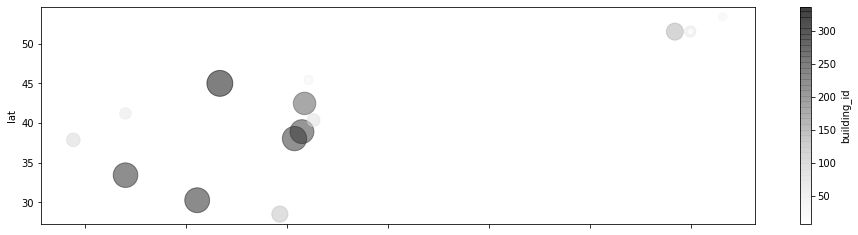

In [3]:
df_plot = building_meta.pivot_table(values='building_id',index=['lng','lat','site_id'], aggfunc='count').reset_index()

df_plot.plot.scatter(x='lng', y='lat', s=df_plot['building_id'] * 2, figsize=(16,4), c ='building_id', alpha=0.5)

Text(0, 0.5, 'amount of meters')

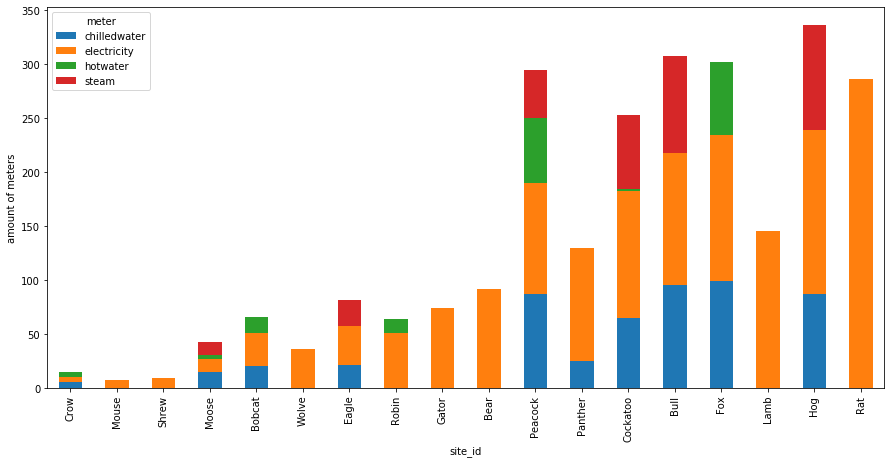

In [4]:
df_plot = building_meta.pivot_table(columns='meter', index='site_id', values='building_id', aggfunc='count').sort_values('electricity')
ax = df_plot.plot.bar(stacked=True, figsize=(15,7))
ax.set_ylabel('amount of meters')

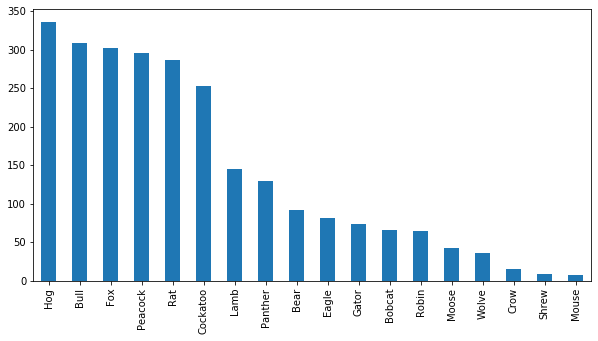

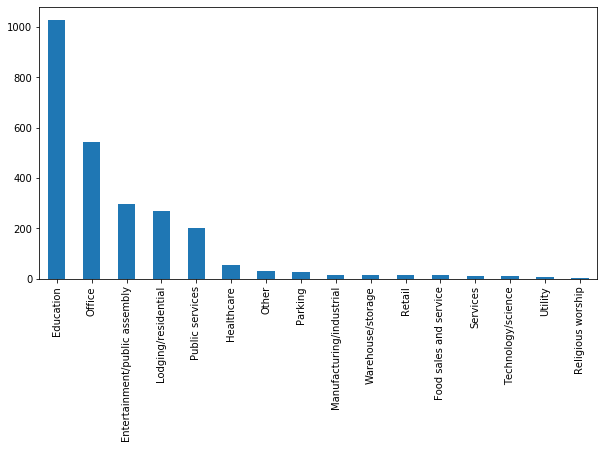

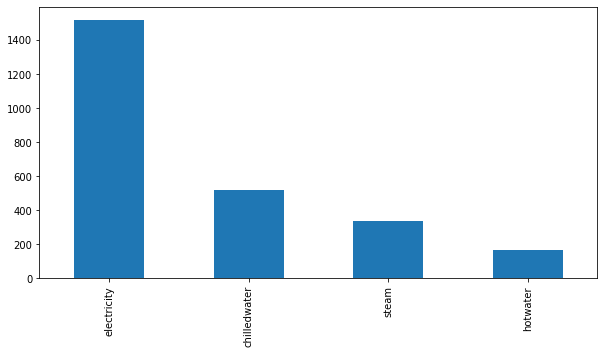

In [5]:
for col in ['site_id', 'primaryspaceusage', 'meter']:
    building_meta[col].value_counts().plot(kind='bar', figsize=(10,5))
    plt.show()

### 2.2 Whole workflow

![title](img/workflow1.png)

![title](img/workflow2.png)

### 2.3 Phase I: Site-based load forecasting model

In [75]:
def add_timestamp_feature(df):
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    
def add_lag_feature(df, window=3):
    cols = ['temperature', 'cloudCover', 'precipIntensity', 'pressure']
    for col in cols:
        df[f'{col}_mean_lag{window}'] = df[col].rolling(window=window, min_periods=0).mean()
        df[f'{col}_max_lag{window}'] = df[col].rolling(window=window, min_periods=0).median()
        
def quantile_meter_reading_df(df, col_meter_reading_log="meter_reading_log1p"):
    # 25th Percentile
    #def q25(x):
    #            return x.quantile(0.25)
    # 50th Percentile
    def q50(x):
                return x.quantile(0.5) 
    # 75th Percentile
    #def q75(x):
    #            return x.quantile(0.75)    
    df_groupby = df.groupby(["meter","timestamp"]).agg(q50_building_meter=(col_meter_reading_log, q50)).reset_index()
    #df_groupby = df.groupby(["meter","timestamp"]).agg(q25_building_meter=(col_meter_reading_log, q25),
    #                                                  q50_building_meter=(col_meter_reading_log, q50),
    #                                                  q75_building_meter=(col_meter_reading_log, q75)).reset_index()

    df_groupby = df_groupby.pivot_table(columns='meter', index='timestamp')
    df_groupby.columns = df_groupby.columns.map('{0[0]}_{0[1]}'.format) 
    df_groupby = df_groupby.reset_index()
    return df_groupby        
        
def fit_lgbm(train, val, seed=666, cat_features=None, num_rounds=200, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
              }

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 50

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

def create_X_y(df_meter_train, meter):
    
    target_df_meter_train = df_meter_train[df_meter_train['meter'] == meter].copy()        
    
    X_train = target_df_meter_train[feature_cols + category_cols]
    y_train = target_df_meter_train['meter_reading_log1p'].values
    
    del target_df_meter_train
    return X_train, y_train

def create_X(df_meter_test, meter):
    
    target_test_df = df_meter_test[df_meter_test['meter'] == meter].copy()        
    X_test = target_test_df[feature_cols + category_cols]
    
    return X_test

def plot_feature_importance(model):
    importance_df = pd.DataFrame(model[1].feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')[-10:]
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()      
    
def pred_all(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, (mindex, model) in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

In [76]:
site_id = 'Peacock'

def preprocess_data(site_id=site_id, df_meter=df_meter):
    #Prepare data
    df_meter_site = df_meter[df_meter['building_id'].str.contains(site_id)].copy()
    building_meta_site = building_meta[building_meta['site_id']==site_id]
    df_weather_site = df_weather[df_weather['site_id']==site_id]

    #Add features
    add_timestamp_feature(df_meter_site)
    df_meter_site.loc[:, 'meter_reading_log1p'] = np.log1p(df_meter_site['meter_reading'])

    df_weather_site = df_weather_site.loc[:, ['temperature', 'cloudCover', 'precipIntensity', 'pressure']]
    df_weather_site = df_weather_site.interpolate(limit_direction='both')
    add_lag_feature(df_weather_site, window=3)
    add_lag_feature(df_weather_site, window=72)
    df_weather_site = df_weather_site.reset_index()

    df_meter_site = df_meter_site.merge(building_meta_site, on=['building_id','meter'])
    df_meter_site = df_meter_site.merge(df_weather_site, on='timestamp')

    for str_col in df_meter_site.dtypes[df_meter_site.dtypes=='object'].index:
        le = LabelEncoder()
        df_meter_site[str_col] = le.fit_transform(df_meter_site[str_col])

    df_meter_train = df_meter_site[df_meter_site['timestamp'].dt.year==2016]
    df_meter_test = df_meter_site[df_meter_site['timestamp'].dt.year==2017]   
    
    df_meter_train = df_meter_train.dropna(subset=['meter_reading'])
    
    category_cols = ['building_id', 'dayofweek', 'primaryspaceusage']
    feature_cols = ['hour', 'sqft', 'yearbuilt', 'numberoffloors', 'temperature',             
           'cloudCover', 'precipIntensity', 'pressure', 
           'temperature_mean_lag3', 'temperature_max_lag3', 'temperature_mean_lag72',
           'cloudCover_mean_lag3', 'cloudCover_max_lag3',
           'precipIntensity_mean_lag3', 'precipIntensity_max_lag3',
           'pressure_mean_lag3', 'pressure_max_lag3',
           'temperature_max_lag72', 'cloudCover_mean_lag72',
           'cloudCover_max_lag72', 'precipIntensity_mean_lag72',
           'precipIntensity_max_lag72', 'pressure_mean_lag72',
           'pressure_max_lag72']
    return df_meter_train, df_meter_test, category_cols, feature_cols

df_meter_train, df_meter_test, category_cols, feature_cols = preprocess_data(site_id=site_id)

meter 0 (672874, 66)
cat_features [63, 64, 65]
0
train 448582 valid 224292
training LGB:


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.06409	valid_1's l2: 1.96152
[100]	training's l2: 0.889221	valid_1's l2: 1.85021
Early stopping, best iteration is:
[93]	training's l2: 0.904269	valid_1's l2: 1.84636
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.9042692933872504}, 'valid_1': {'l2': 1.8463562493014596}})
1
train 448583 valid 224291
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.47466	valid_1's l2: 1.11348
[100]	training's l2: 1.23439	valid_1's l2: 0.942671
[150]	training's l2: 1.14573	valid_1's l2: 0.901593
[200]	training's l2: 1.08036	valid_1's l2: 0.884119
Did not meet early stopping. Best iteration is:
[200]	training's l2: 1.08036	valid_1's l2: 0.884119
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.0803601855480673}, 'valid_1': {'l2': 0.8841191206764555}})
2
train 448583 valid 224291
training LGB:
Training until validation scores don't improve for 20 roun

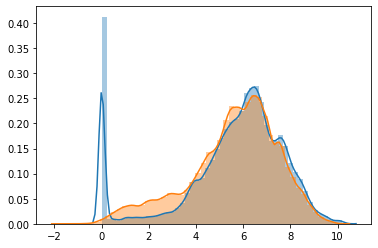

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


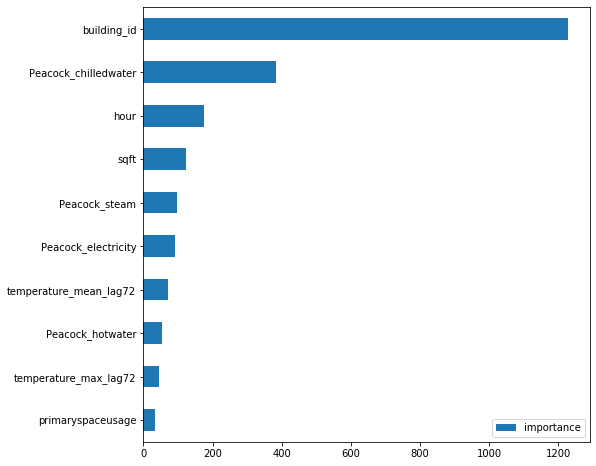

meter 1 (834249, 66)
cat_features [63, 64, 65]
0
train 556166 valid 278083
training LGB:


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.189575	valid_1's l2: 0.183012
[100]	training's l2: 0.138504	valid_1's l2: 0.162571
[150]	training's l2: 0.118551	valid_1's l2: 0.154962
Early stopping, best iteration is:
[157]	training's l2: 0.115821	valid_1's l2: 0.153574
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.11582136273603501}, 'valid_1': {'l2': 0.15357446642623107}})
1
train 556166 valid 278083
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.170308	valid_1's l2: 0.339014
[100]	training's l2: 0.121621	valid_1's l2: 0.312716
[150]	training's l2: 0.0997727	valid_1's l2: 0.306763
Early stopping, best iteration is:
[135]	training's l2: 0.105064	valid_1's l2: 0.306014
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.10506425620310578}, 'valid_1': {'l2': 0.30601360659438764}})
2
train 556166 valid 278083
training LGB:
Training until validation scores don't improve for 20 r

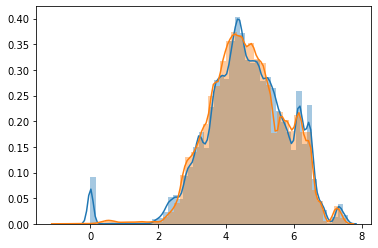

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


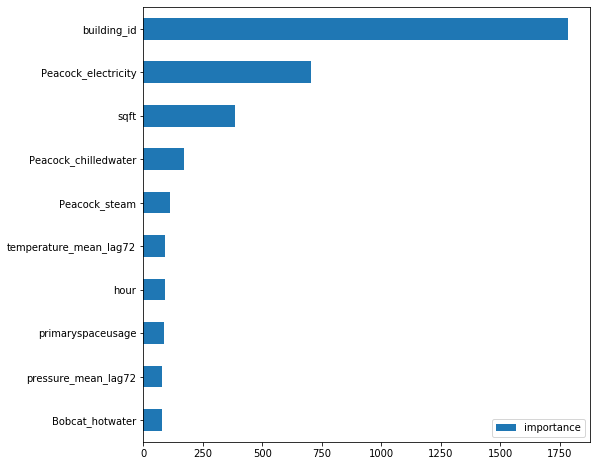

meter 2 (461726, 66)
cat_features [63, 64, 65]
0
train 307817 valid 153909
training LGB:


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.89103	valid_1's l2: 2.31772
[100]	training's l2: 1.67857	valid_1's l2: 2.11524
[150]	training's l2: 1.59188	valid_1's l2: 2.05798
[200]	training's l2: 1.53468	valid_1's l2: 2.02123
Did not meet early stopping. Best iteration is:
[200]	training's l2: 1.53468	valid_1's l2: 2.02123
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.5346842674112189}, 'valid_1': {'l2': 2.021232758860115}})
1
train 307817 valid 153909
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.95931	valid_1's l2: 2.01661
[100]	training's l2: 1.70351	valid_1's l2: 1.80969
[150]	training's l2: 1.59301	valid_1's l2: 1.75238
[200]	training's l2: 1.51391	valid_1's l2: 1.71775
Did not meet early stopping. Best iteration is:
[200]	training's l2: 1.51391	valid_1's l2: 1.71775
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.5139056837885463}, 'valid_1': {'l2': 1.71775185805

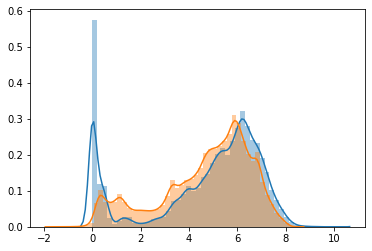

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


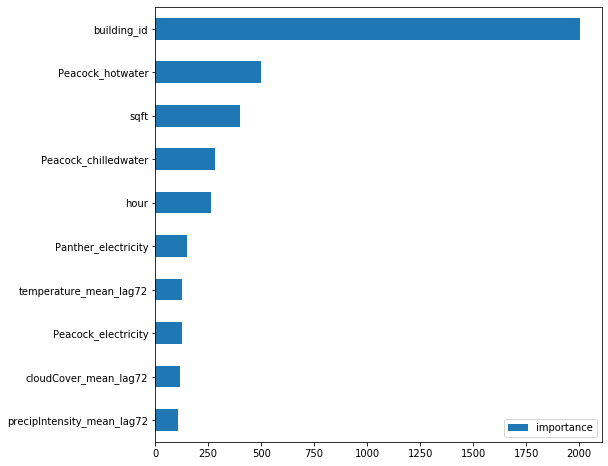

meter 3 (348324, 66)
cat_features [63, 64, 65]
0
train 232216 valid 116108
training LGB:


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.834017	valid_1's l2: 1.18401
[100]	training's l2: 0.725753	valid_1's l2: 1.1494
Early stopping, best iteration is:
[125]	training's l2: 0.699583	valid_1's l2: 1.14237
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.6995834083475356}, 'valid_1': {'l2': 1.1423683607068407}})
1
train 232216 valid 116108
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.802776	valid_1's l2: 1.05056
[100]	training's l2: 0.672361	valid_1's l2: 0.978876
Early stopping, best iteration is:
[113]	training's l2: 0.654997	valid_1's l2: 0.970977
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.6549971475745324}, 'valid_1': {'l2': 0.9709769805955254}})
2
train 232216 valid 116108
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.854257	valid_1's l2: 1.00411
[100]	training's l2: 0.735945	valid_1's l2: 0.96243
Early 

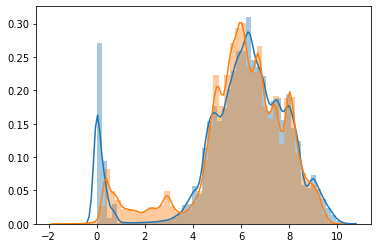

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


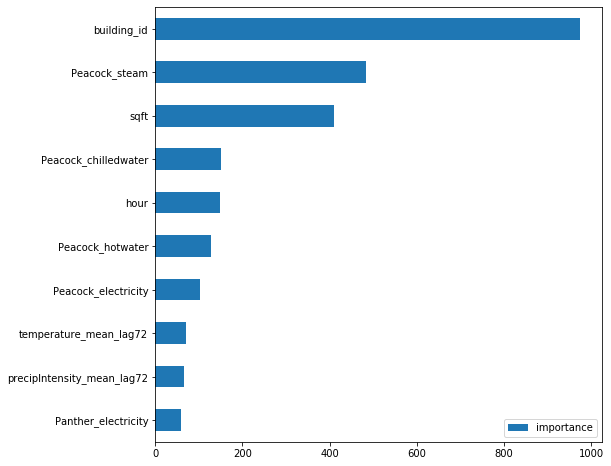

meter:  0
iterations 1
predicting 0-th model


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



predicting 1-th model



predicting 2-th model


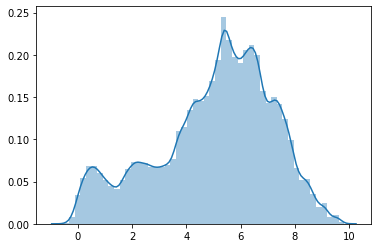

(763164, 66) (763164,)
meter:  1
iterations 1
predicting 0-th model


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



predicting 1-th model



predicting 2-th model


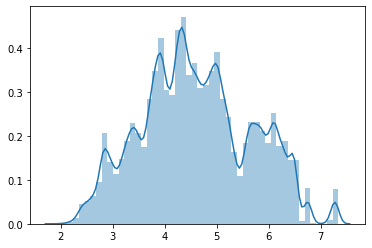

(903516, 66) (903516,)
meter:  2
iterations 1
predicting 0-th model


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



predicting 1-th model



predicting 2-th model


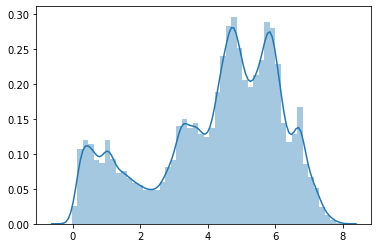

(526320, 66) (526320,)
meter:  3
iterations 1
predicting 0-th model


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



predicting 1-th model



predicting 2-th model


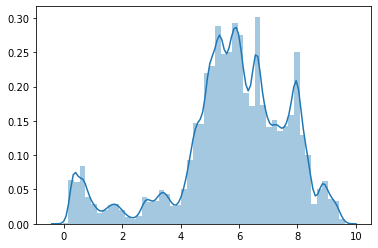

(394740, 66) (394740,)


In [79]:
#Train Phase I model
def model_train_test(site_id=site_id, df_meter_train=df_meter_train,
                     category_cols=category_cols, feature_cols=feature_cols):
    
    #train models
    for meter in df_meter_train['meter'].unique():
        X_train, y_train = create_X_y(df_meter_train, meter=meter)
        y_valid_pred_total = np.zeros(X_train.shape[0])
        gc.collect()
        print('meter', meter, X_train.shape)

        cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
        print('cat_features', cat_features)

        exec('models' +str(meter)+ '=[]')

        df_meter_train_temp = df_meter_train[df_meter_train['meter']==meter].copy()

        mindex = 0
        kf = StratifiedKFold(n_splits=3)
        for train_idx, valid_idx in kf.split(df_meter_train_temp, df_meter_train_temp['building_id']):
            train_data = X_train.iloc[train_idx,:], y_train[train_idx]
            valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

            print (mindex)

            print('train', len(train_idx), 'valid', len(valid_idx))
            model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                                lr=0.05, bf=0.7)
            y_valid_pred_total[valid_idx] = y_pred_valid
            exec('models' +str(meter)+ '.append([mindex, model])')
            mindex = mindex+1
            gc.collect()

        try:
            sns.distplot(y_train)
            sns.distplot(y_valid_pred_total)
            plt.show()
        except:
            pass

        del X_train, y_train
        gc.collect()
    
        exec('plot_feature_importance(models' +str(meter)+'[0])')
        plt.show()
    
    #predict test data
    for meter in df_meter_test['meter'].unique():
        print('meter: ', meter)
        X_test = create_X(df_meter_test, meter=meter)
        gc.collect()

        exec('y_test' +str(meter)+ '= pred_all(X_test, models' +str(meter)+ ')')
        exec('sns.distplot(y_test' +str(meter)+ ')')
        plt.show()

        exec('print(X_test.shape, y_test' +str(meter)+ '.shape)')

        del X_test
        gc.collect()    

    for meter in df_meter_test['meter'].unique():
        exec('df_meter_test.loc[df_meter_test["meter"] == meter,"meter_reading_pred"] = np.expm1(y_test' +str(meter)+ ')')

    df_meter_test.loc[df_meter_test['meter_reading_pred'] < 0, 'meter_reading_pred'] = 0  
    df_meter_test['error_log'] = (np.log1p(df_meter_test['meter_reading']) - np.log1p(df_meter_test['meter_reading_pred']))**2

    return df_meter_test        

df_meter_test = model_train_test(site_id=site_id, df_meter_train=df_meter_train,
                                 category_cols=category_cols, feature_cols=feature_cols)

In [7]:
(df_meter_test['error_log'].mean())**0.5

1.6852601749759655

In [ ]:
for building_id, meter in df_meter_test[['building_id','meter']].drop_duplicates().itertuples(index=False):
    print('building_id: ', building_id)
    print('meter: ', meter)    
    df_plot = df_meter_train[(df_meter_train['building_id']==building_id)&(df_meter_train['meter']==meter)][['timestamp','meter_reading']]\
    .append(df_meter_test[(df_meter_test['building_id']==building_id)&(df_meter_test['meter']==meter)][['timestamp','meter_reading','meter_reading_pred']],sort=True)
    df_plot = df_plot.set_index('timestamp')
    df_plot.plot(figsize=(15,5),alpha=0.5)
    plt.show()
    print('-----------------------------------------------------------------')

In [9]:
%%capture
df_meter_test_merged = pd.DataFrame()

for site_id in building_meta['site_id'].unique():
    df_meter_train, df_meter_test, category_cols, feature_cols = preprocess_data(site_id=site_id)
    
    df_meter_test = model_train_test(site_id=site_id, df_meter_train=df_meter_train,
                                     category_cols=category_cols, feature_cols=feature_cols)
    
    df_meter_test_merged = pd.concat([df_meter_test_merged, df_meter_test[['row_id','meter_reading_pred']]], axis=0)

In [10]:
df_meter = df_meter.merge(df_meter_test_merged, on='row_id', how='left')
df_meter['error_log_phase1'] = (np.log1p(df_meter['meter_reading_pred']) - np.log1p(df_meter['meter_reading']))**2

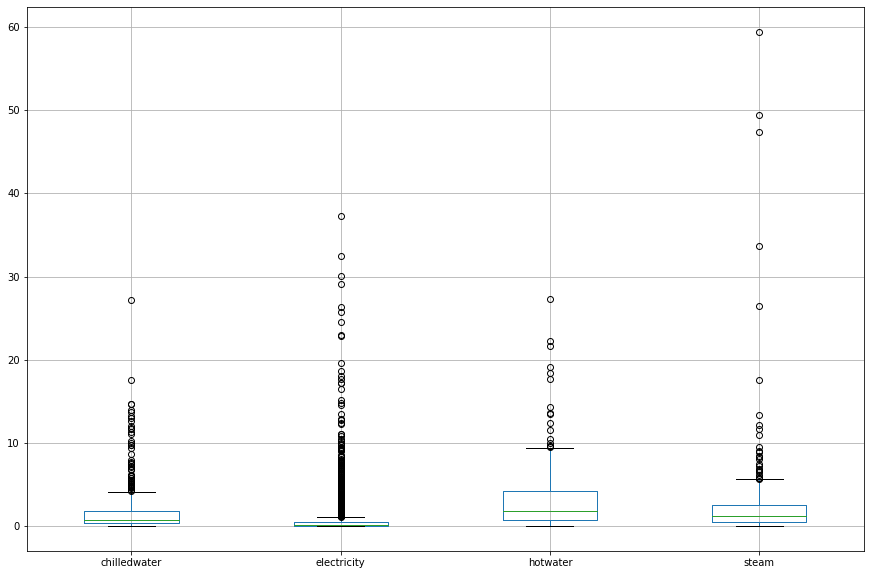

In [11]:
df_error_pivot = df_meter.merge(building_meta, on=['building_id', 'meter']).\
                 pivot_table(index='building_id',columns='meter',values='error_log_phase1',aggfunc='mean')
df_error_pivot.boxplot(figsize=(15,10))

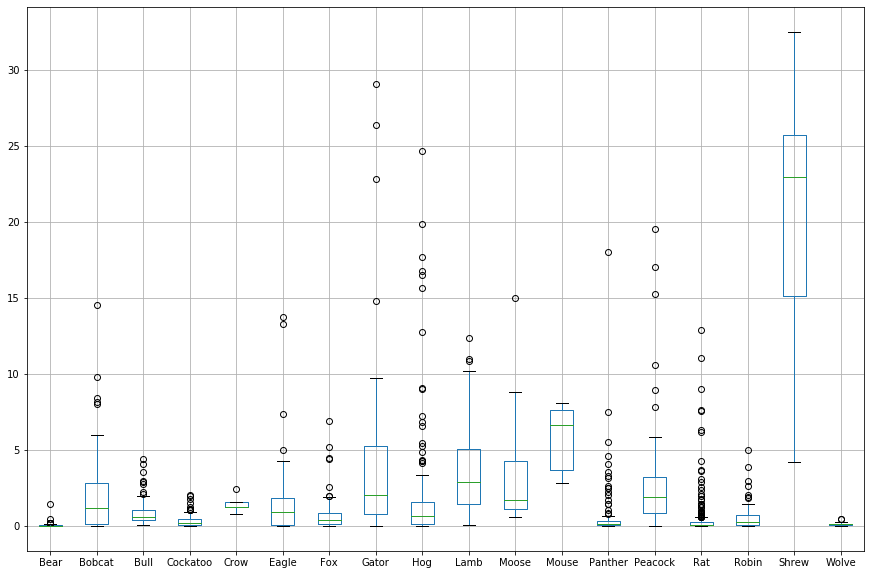

In [12]:
df_error_pivot = df_meter.merge(building_meta, on=['building_id', 'meter']).\
                 pivot_table(index='building_id',columns='site_id',values='error_log_phase1',aggfunc='mean')
df_error_pivot.boxplot(figsize=(15,10))

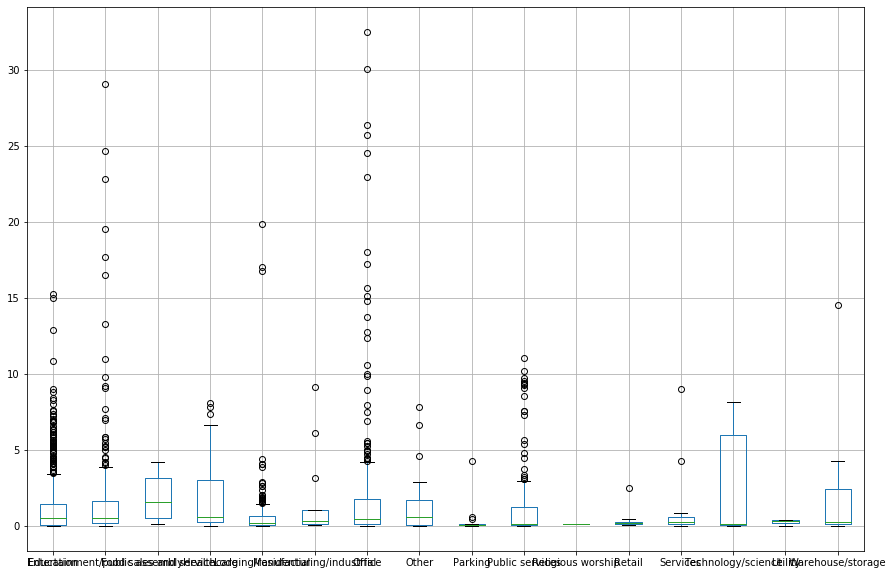

In [13]:
df_error_pivot = df_meter.merge(building_meta, on=['building_id', 'meter']).\
                 pivot_table(index='building_id',columns='primaryspaceusage',values='error_log_phase1',aggfunc='mean')
df_error_pivot.boxplot(figsize=(15,10))

## 2.4 Phase II: Post-processed forecasting model

In [14]:
df_meter_quantile = df_meter[['timestamp','building_id','meter','meter_reading','meter_reading_pred']].copy()
df_meter_quantile.loc[~df_meter_quantile['meter_reading_pred'].isna(), 'meter_reading'] = df_meter_quantile.loc[~df_meter_quantile['meter_reading_pred'].isna(), 'meter_reading_pred']
df_meter_quantile = df_meter_quantile.drop('meter_reading_pred', axis=1)
df_meter_quantile = df_meter_quantile.merge(building_meta, on=['building_id', 'meter'])
df_meter_quantile['meter_reading_log1p'] = np.log1p(df_meter_quantile['meter_reading'])
df_meter_quantile['availability'] = ~df_meter_quantile['meter_reading_log1p'].isna()
df_meter_quantile = df_meter_quantile.groupby(["site_id", "meter","timestamp"]).agg(median_building_meter=('meter_reading_log1p', 'median'),
                                                                                    availability_building_meter=('availability', 'mean')).reset_index()
df_meter_quantile.loc[df_meter_quantile['availability_building_meter']< 0.5, 'median_building_meter'] = np.nan
df_meter_quantile = df_meter_quantile.pivot_table(columns=["site_id", 'meter'], values='median_building_meter', index='timestamp')
df_meter_quantile.columns =df_meter_quantile.columns.map('{0[0]}_{0[1]}'.format) 
df_meter_quantile = df_meter_quantile.reset_index()
df_meter_quantile = df_meter_quantile[df_meter_quantile.columns[(~df_meter_quantile.isna()).sum()/len(df_meter_quantile)>0.5]]
df_meter_quantile

,timestamp,Bear_electricity,Bobcat_electricity,Bobcat_hotwater,Bull_chilledwater,Bull_electricity,Bull_steam,Cockatoo_chilledwater,Cockatoo_electricity,Cockatoo_hotwater,...,Panther_electricity,Peacock_chilledwater,Peacock_electricity,Peacock_hotwater,Peacock_steam,Rat_electricity,Robin_electricity,Robin_hotwater,Shrew_electricity,Wolve_electricity
0,2016-01-01 00:00:00,4.081800,4.143890,6.509043,0.000000,0.000000,0.000000,2.046544,4.072866,7.318230,...,NaN,5.437703,4.392537,5.722771,6.297160,3.560902,3.529297,3.027178,3.903991,3.592154
1,2016-01-01 01:00:00,4.128601,4.108570,5.359759,4.264948,4.290459,5.316562,2.020050,4.027136,7.333029,...,NaN,5.406604,4.422277,5.844663,6.324749,3.572902,4.241327,3.992082,4.641502,3.608572
2,2016-01-01 02:00:00,4.127212,4.168600,5.564485,4.270860,4.276666,5.214936,1.998909,4.001407,7.368015,...,NaN,5.370892,4.390341,5.886179,6.163371,3.549033,4.208417,4.615121,4.617099,3.595383
3,2016-01-01 03:00:00,4.101638,4.197203,5.546695,4.264948,4.290459,5.231376,2.030868,4.018183,7.291829,...,NaN,5.154931,4.372734,5.627437,6.224474,3.551913,4.197202,4.343130,4.630838,3.585288
4,2016-01-01 04:00:00,4.097382,4.056125,5.510143,4.172324,4.290459,5.231376,2.026660,4.085976,7.291192,...,NaN,5.074093,4.359014,5.745878,6.129415,3.559118,4.229749,4.161573,4.745801,3.585283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2017-12-31 19:00:00,4.112940,3.867424,3.068223,4.272350,4.329593,5.402639,1.720348,4.287860,7.515986,...,4.121569,4.151786,4.626749,6.186483,6.856431,3.957331,4.512877,3.472336,4.834989,3.821216
17540,2017-12-31 20:00:00,4.102014,3.867424,3.065067,4.263900,4.333343,5.425079,1.629498,4.248056,7.513030,...,4.122664,4.153084,4.626749,6.189455,6.856460,3.955587,4.509909,3.411537,4.788577,3.759926
17541,2017-12-31 21:00:00,4.058939,3.840450,3.056750,4.260396,4.323248,5.429709,1.601508,4.241147,7.495760,...,4.122724,4.153084,4.627860,6.196289,6.856460,3.948787,4.486773,3.305107,4.722579,3.707370
17542,2017-12-31 22:00:00,3.993090,3.828660,3.059328,4.248984,4.309147,5.429709,1.586303,4.222188,7.493342,...,4.126034,4.148730,4.627860,6.105155,6.857510,3.947548,4.467765,2.993656,4.675278,3.662869


Bear_electricity


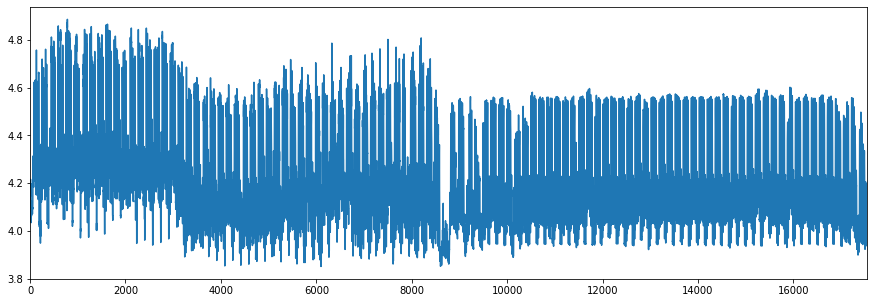

Bobcat_electricity


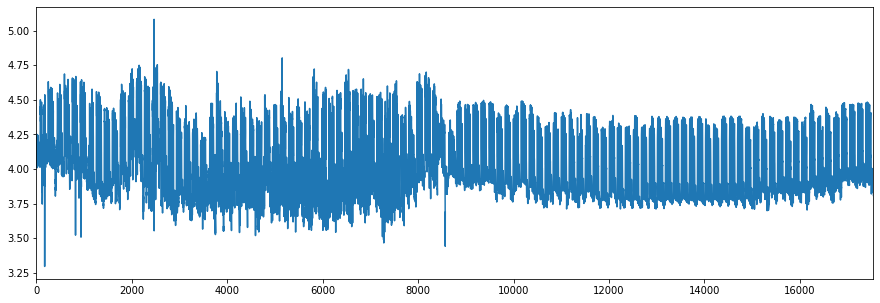

Bobcat_hotwater


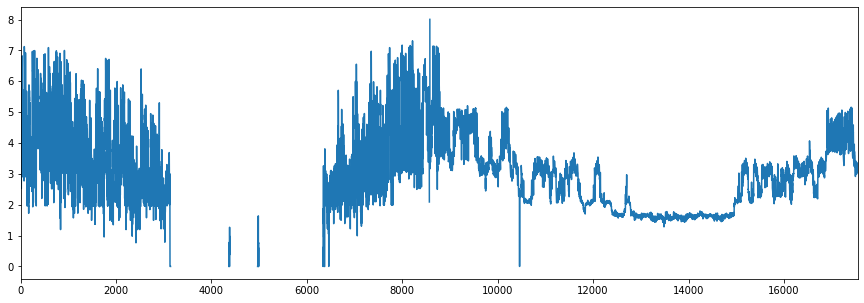

Bull_chilledwater


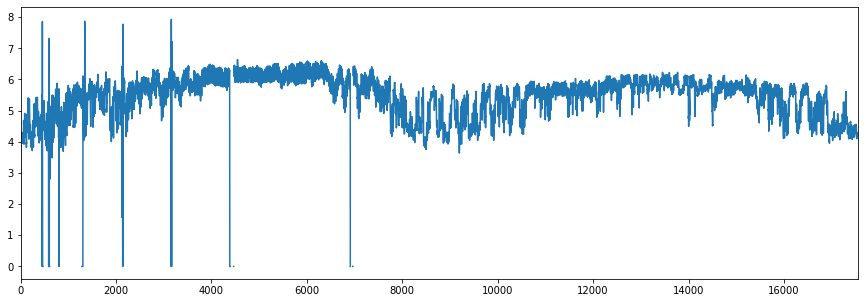

Bull_electricity


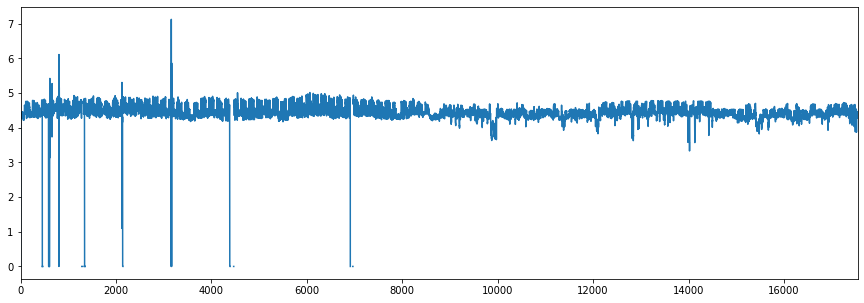

Bull_steam


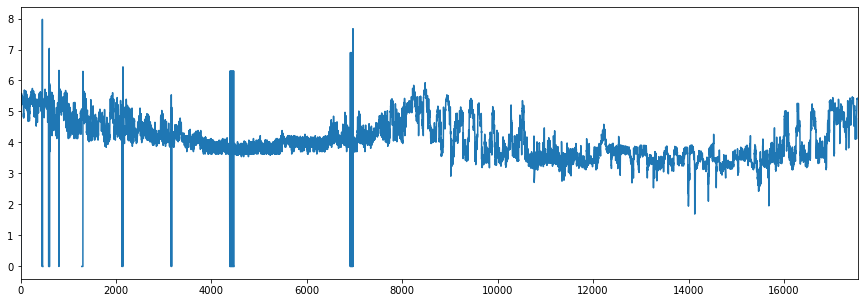

Cockatoo_chilledwater


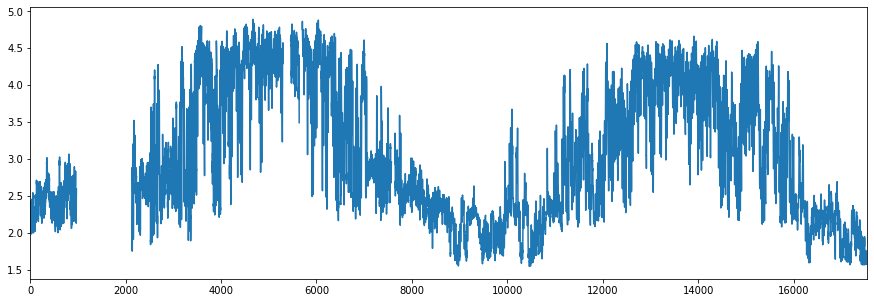

Cockatoo_electricity


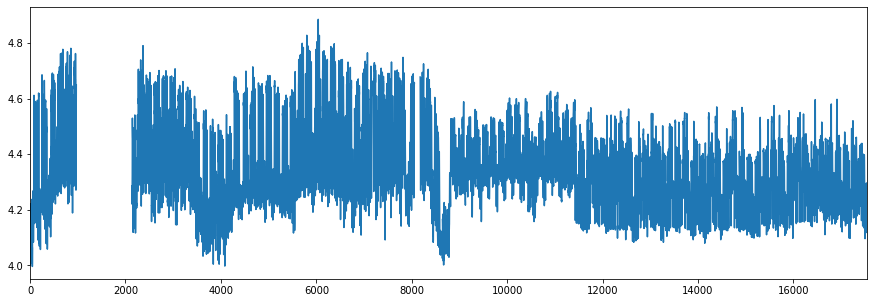

Cockatoo_hotwater


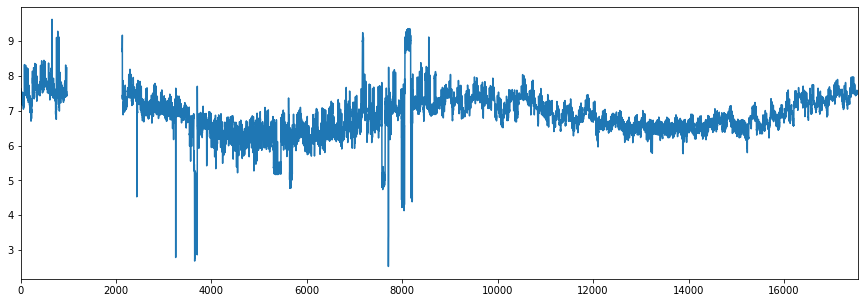

Cockatoo_steam


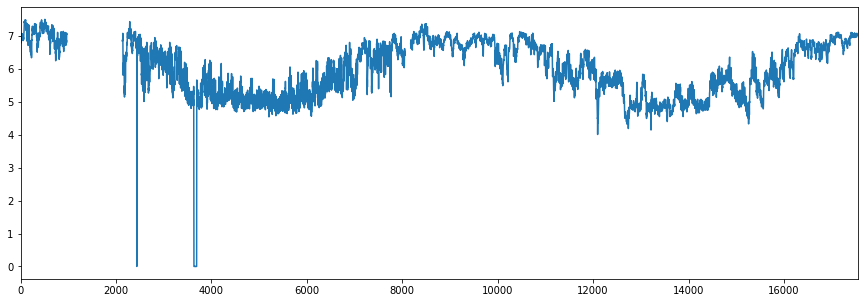

Crow_chilledwater


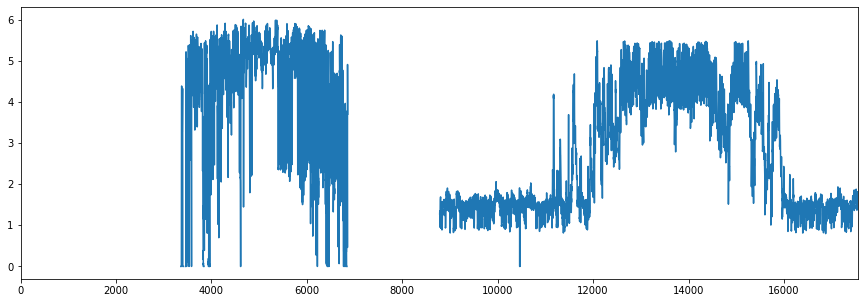

Crow_electricity


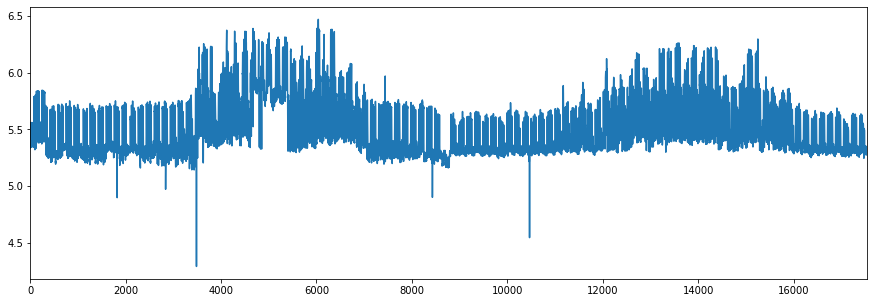

Crow_hotwater


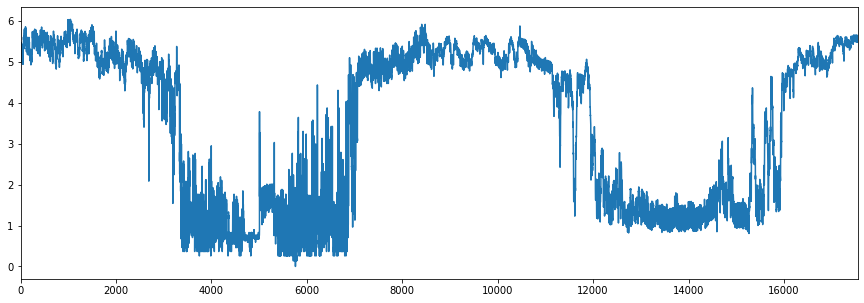

Eagle_chilledwater


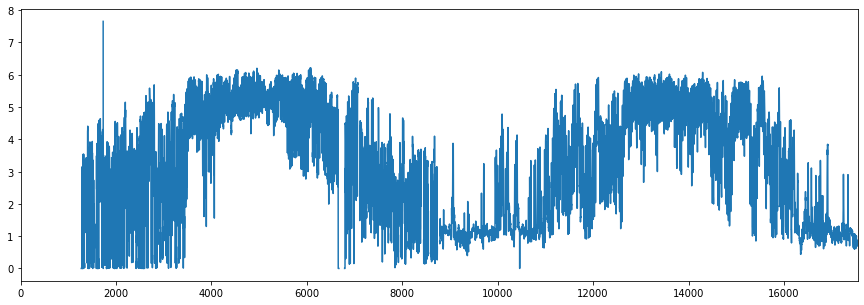

Eagle_electricity


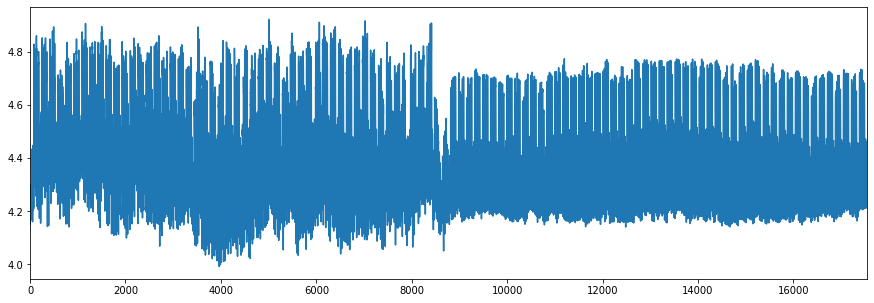

Eagle_steam


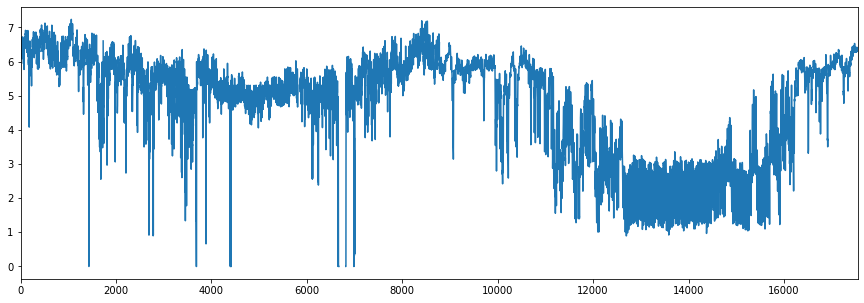

Fox_chilledwater


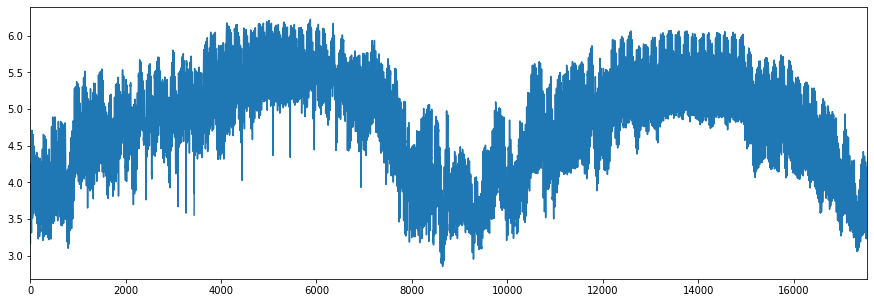

Fox_electricity


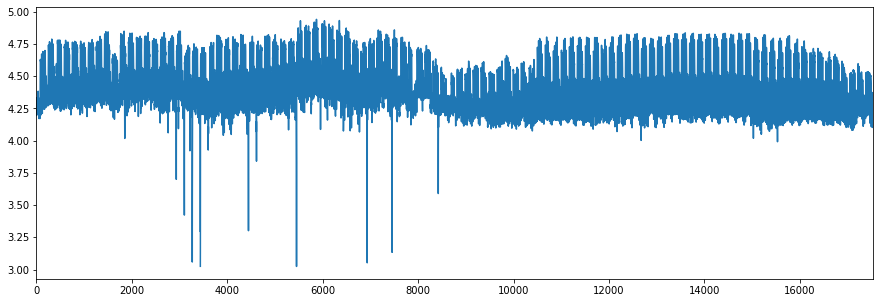

Fox_hotwater


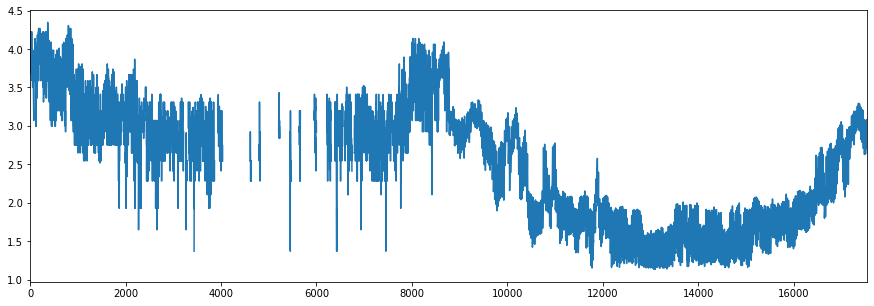

Hog_chilledwater


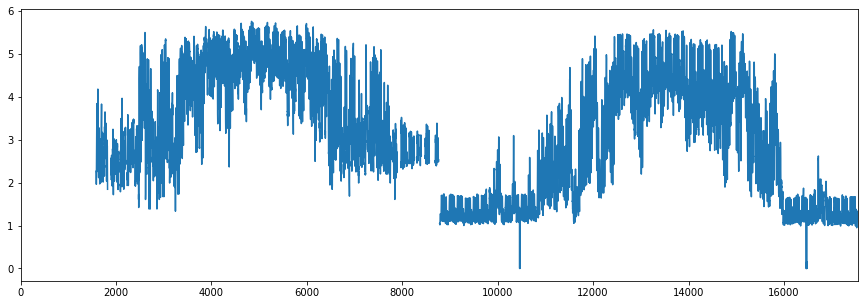

Hog_electricity


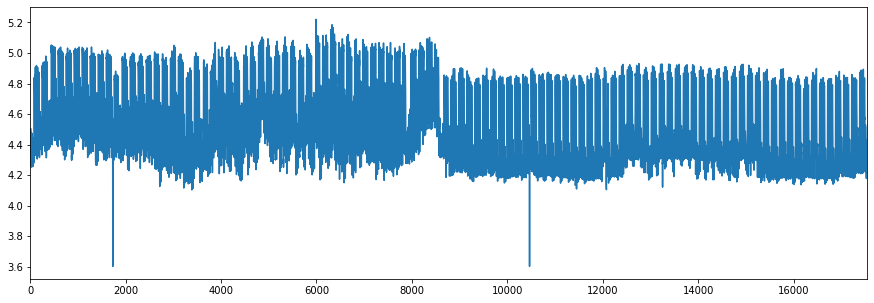

Hog_steam


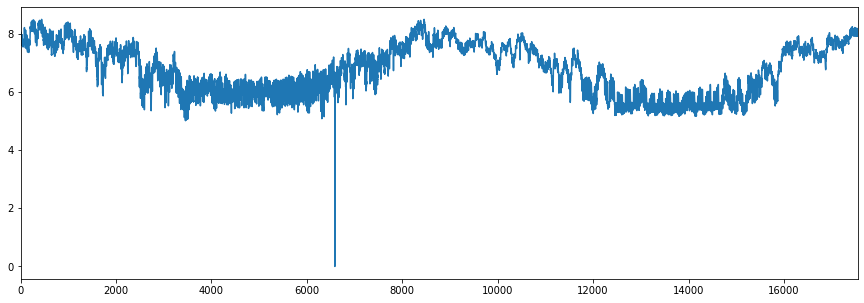

Lamb_electricity


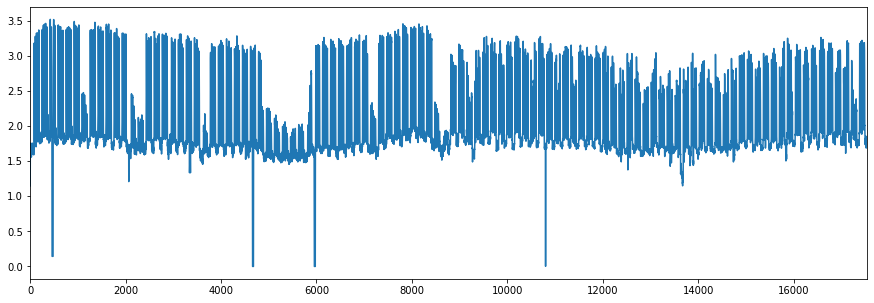

Moose_chilledwater


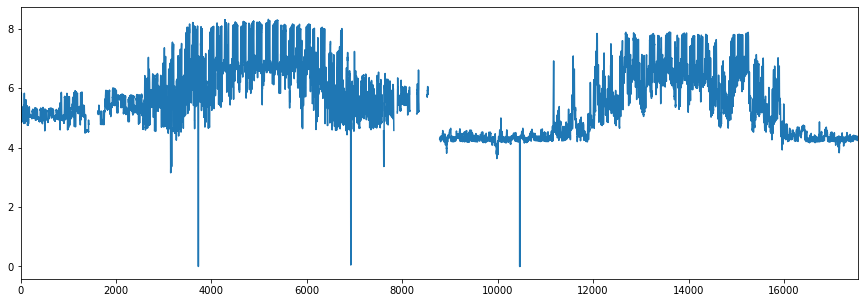

Moose_electricity


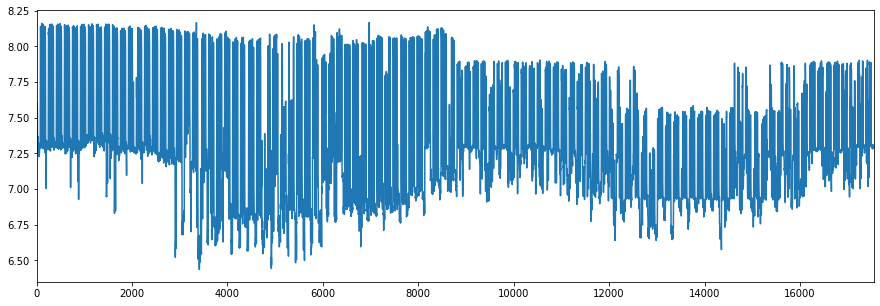

Moose_hotwater


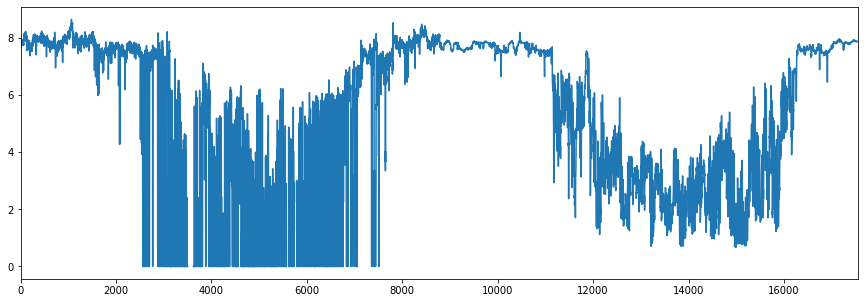

Moose_steam


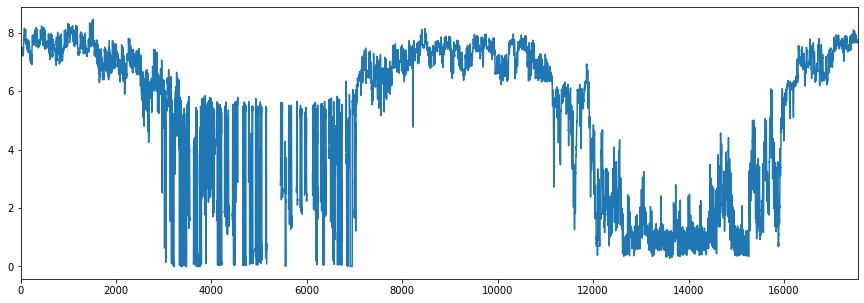

Mouse_electricity


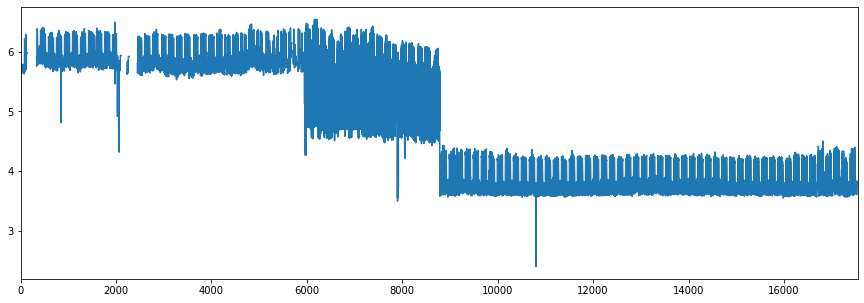

Panther_chilledwater


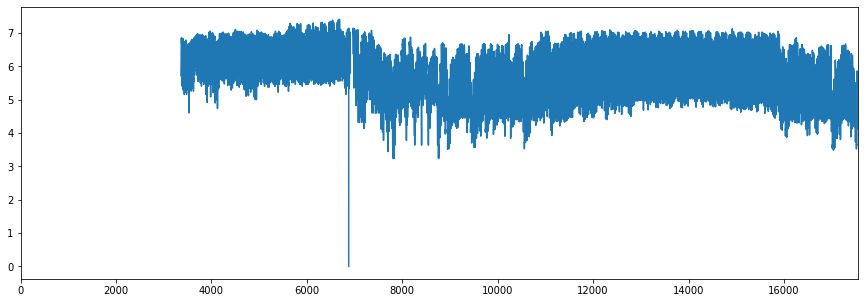

Panther_electricity


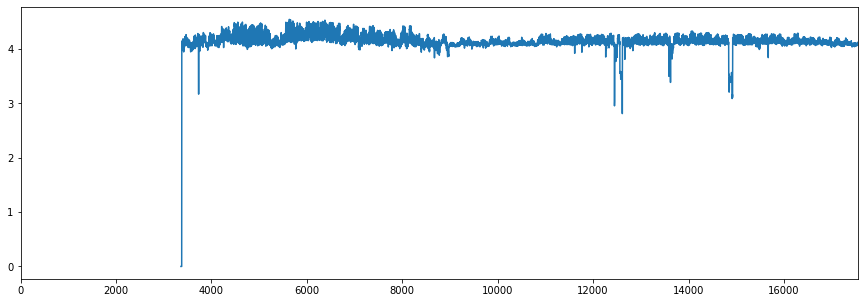

Peacock_chilledwater


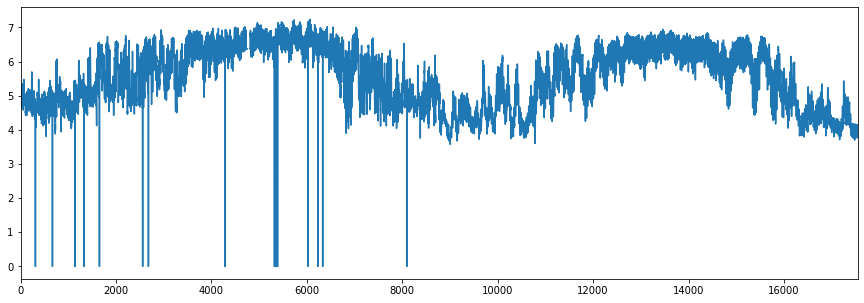

Peacock_electricity


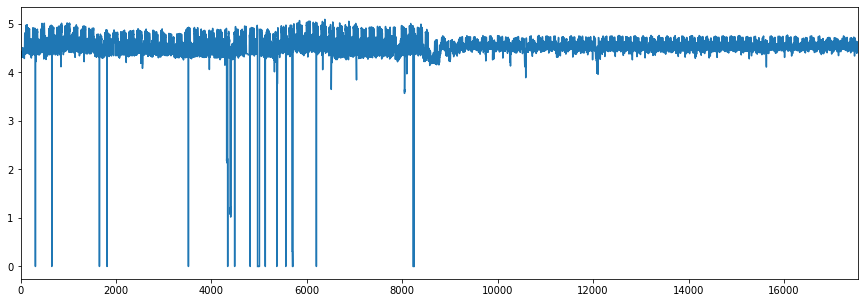

Peacock_hotwater


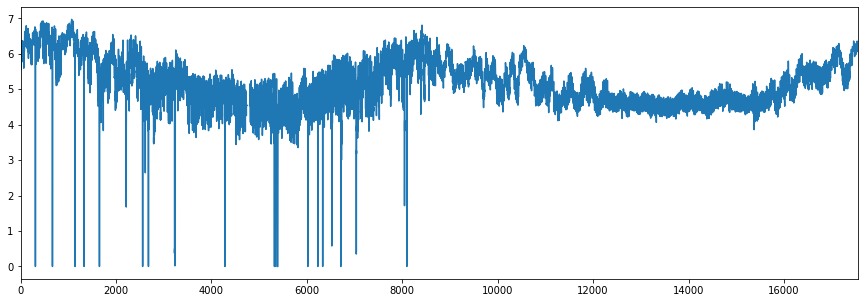

Peacock_steam


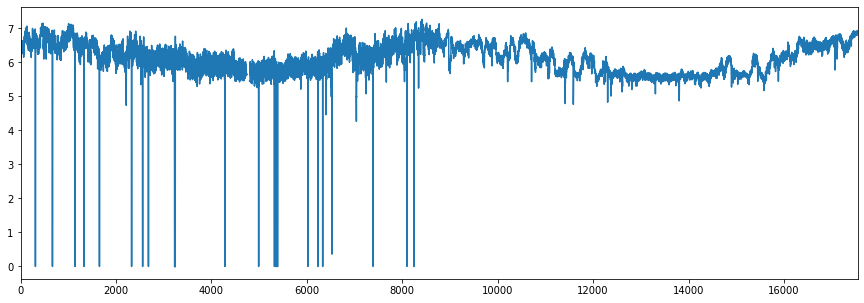

Rat_electricity


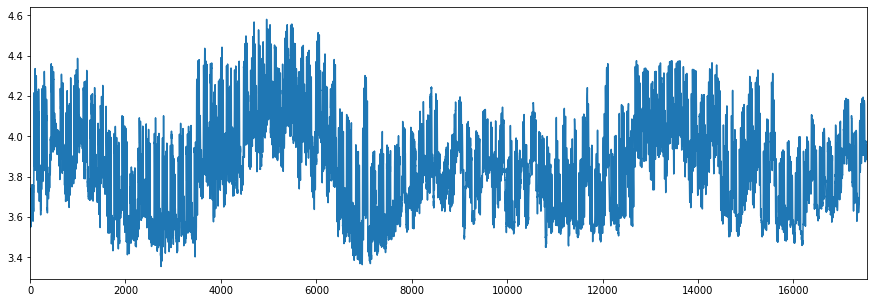

Robin_electricity


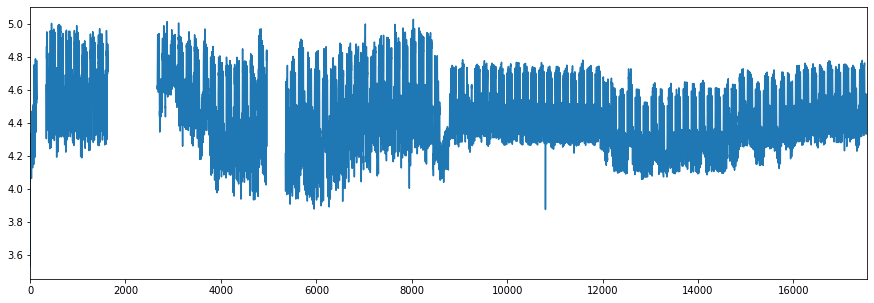

Robin_hotwater


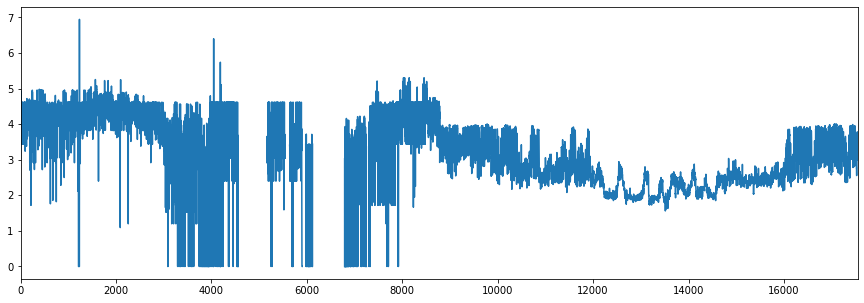

Shrew_electricity


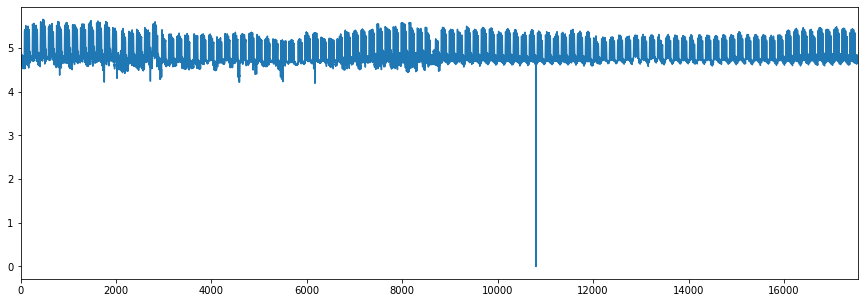

Wolve_electricity


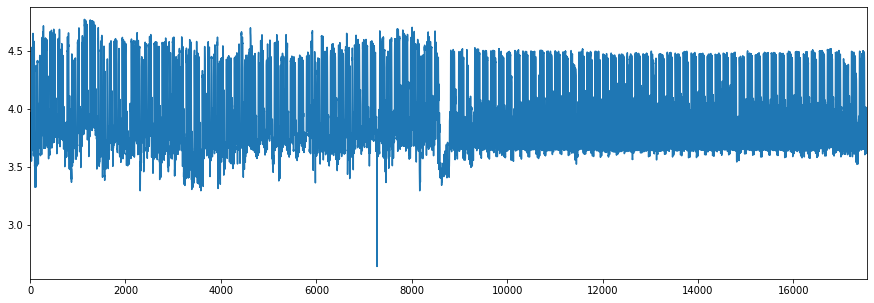

In [15]:
for col in df_meter_quantile.columns[1:]:
    print(col)
    df_meter_quantile[col].plot(figsize=(15,5))
    plt.show()

meter 0 (672874, 66)
cat_features [63, 64, 65]
0
train 448582 valid 224292
training LGB:


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.06409	valid_1's l2: 1.96152
[100]	training's l2: 0.889221	valid_1's l2: 1.85021
Early stopping, best iteration is:
[93]	training's l2: 0.904269	valid_1's l2: 1.84636
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.9042692933872504}, 'valid_1': {'l2': 1.8463562493014596}})
1
train 448583 valid 224291
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.47466	valid_1's l2: 1.11348
[100]	training's l2: 1.23439	valid_1's l2: 0.942671
[150]	training's l2: 1.14573	valid_1's l2: 0.901593
[200]	training's l2: 1.08036	valid_1's l2: 0.884119
Did not meet early stopping. Best iteration is:
[200]	training's l2: 1.08036	valid_1's l2: 0.884119
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.0803601855480673}, 'valid_1': {'l2': 0.8841191206764555}})
2
train 448583 valid 224291
training LGB:
Training until validation scores don't improve for 20 roun

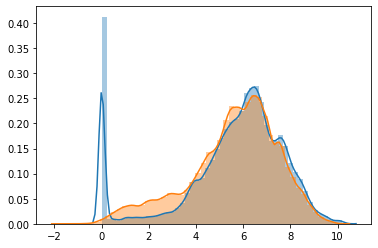

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


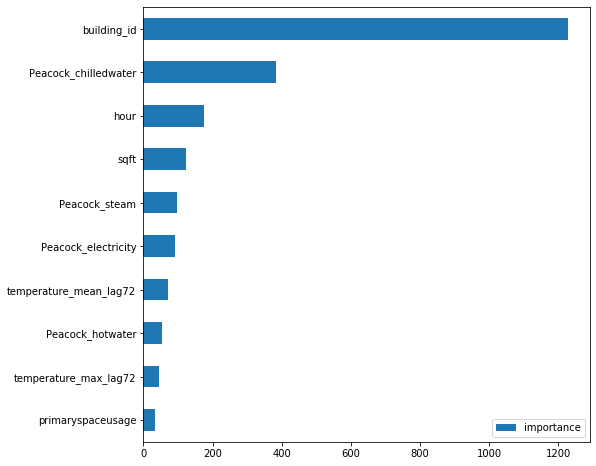

meter 1 (834249, 66)
cat_features [63, 64, 65]
0
train 556166 valid 278083
training LGB:


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.189575	valid_1's l2: 0.183012
[100]	training's l2: 0.138504	valid_1's l2: 0.162571
[150]	training's l2: 0.118551	valid_1's l2: 0.154962
Early stopping, best iteration is:
[157]	training's l2: 0.115821	valid_1's l2: 0.153574
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.11582136273603501}, 'valid_1': {'l2': 0.15357446642623107}})
1
train 556166 valid 278083
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.170308	valid_1's l2: 0.339014
[100]	training's l2: 0.121621	valid_1's l2: 0.312716
[150]	training's l2: 0.0997727	valid_1's l2: 0.306763
Early stopping, best iteration is:
[135]	training's l2: 0.105064	valid_1's l2: 0.306014
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.10506425620310578}, 'valid_1': {'l2': 0.30601360659438764}})
2
train 556166 valid 278083
training LGB:
Training until validation scores don't improve for 20 r

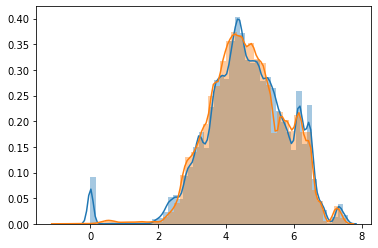

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


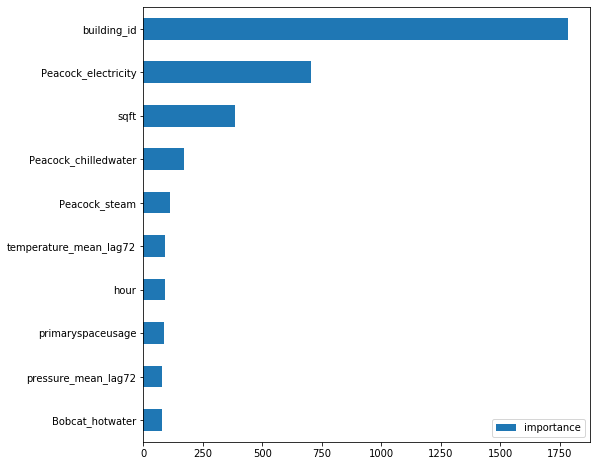

meter 2 (461726, 66)
cat_features [63, 64, 65]
0
train 307817 valid 153909
training LGB:


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.89103	valid_1's l2: 2.31772
[100]	training's l2: 1.67857	valid_1's l2: 2.11524
[150]	training's l2: 1.59188	valid_1's l2: 2.05798
[200]	training's l2: 1.53468	valid_1's l2: 2.02123
Did not meet early stopping. Best iteration is:
[200]	training's l2: 1.53468	valid_1's l2: 2.02123
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.5346842674112189}, 'valid_1': {'l2': 2.021232758860115}})
1
train 307817 valid 153909
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 1.95931	valid_1's l2: 2.01661
[100]	training's l2: 1.70351	valid_1's l2: 1.80969
[150]	training's l2: 1.59301	valid_1's l2: 1.75238
[200]	training's l2: 1.51391	valid_1's l2: 1.71775
Did not meet early stopping. Best iteration is:
[200]	training's l2: 1.51391	valid_1's l2: 1.71775
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.5139056837885463}, 'valid_1': {'l2': 1.71775185805

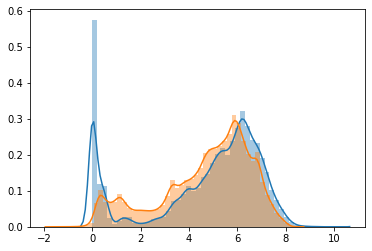

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


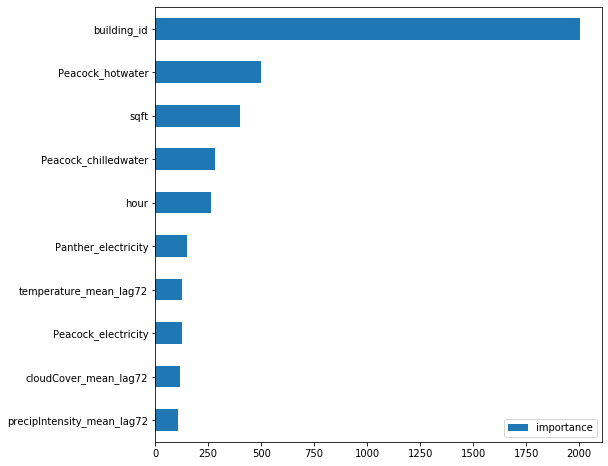

meter 3 (348324, 66)
cat_features [63, 64, 65]
0
train 232216 valid 116108
training LGB:


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.834017	valid_1's l2: 1.18401
[100]	training's l2: 0.725753	valid_1's l2: 1.1494
Early stopping, best iteration is:
[125]	training's l2: 0.699583	valid_1's l2: 1.14237
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.6995834083475356}, 'valid_1': {'l2': 1.1423683607068407}})
1
train 232216 valid 116108
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.802776	valid_1's l2: 1.05056
[100]	training's l2: 0.672361	valid_1's l2: 0.978876
Early stopping, best iteration is:
[113]	training's l2: 0.654997	valid_1's l2: 0.970977
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.6549971475745324}, 'valid_1': {'l2': 0.9709769805955254}})
2
train 232216 valid 116108
training LGB:
Training until validation scores don't improve for 20 rounds.
[50]	training's l2: 0.854257	valid_1's l2: 1.00411
[100]	training's l2: 0.735945	valid_1's l2: 0.96243
Early 

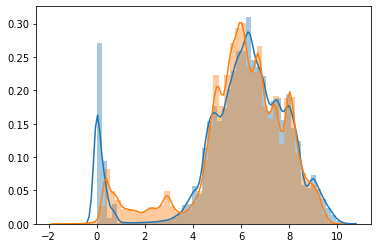

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


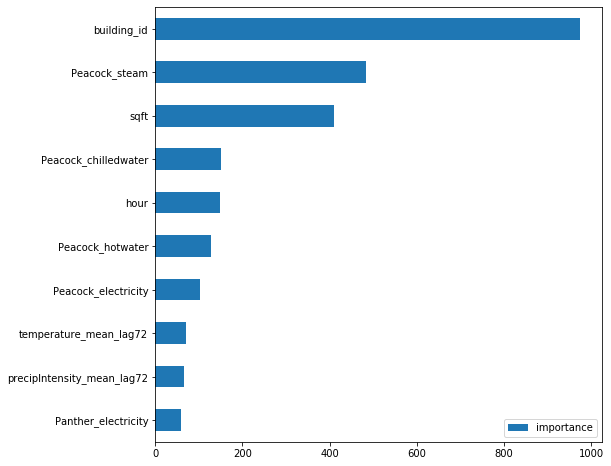

meter:  0
iterations 1
predicting 0-th model


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



predicting 1-th model



predicting 2-th model


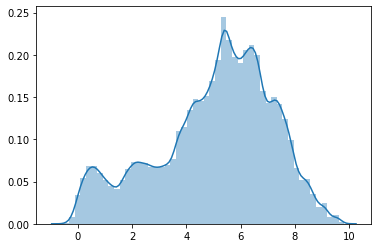

(763164, 66) (763164,)
meter:  1
iterations 1
predicting 0-th model


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



predicting 1-th model



predicting 2-th model


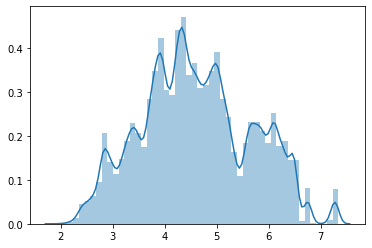

(903516, 66) (903516,)
meter:  2
iterations 1
predicting 0-th model


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



predicting 1-th model



predicting 2-th model


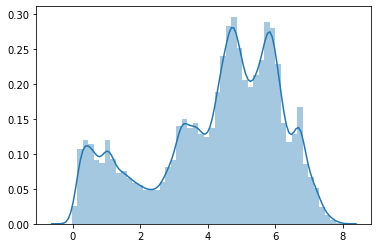

(526320, 66) (526320,)
meter:  3
iterations 1
predicting 0-th model


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



predicting 1-th model



predicting 2-th model


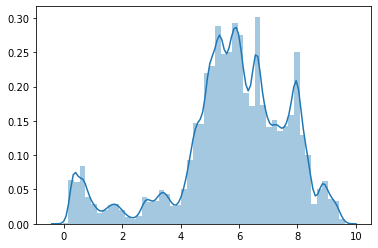

(394740, 66) (394740,)


In [80]:
site_id = 'Peacock'

df_meter_train, df_meter_test, category_cols, feature_cols = preprocess_data(site_id=site_id)

def add_similarity_feat(df_meter_train=df_meter_train, df_meter_test=df_meter_test, feature_cols=feature_cols):
    # Add similarity feature
    df_meter_train = df_meter_train.merge(df_meter_quantile, on=['timestamp'], how='left')
    df_meter_test = df_meter_test.merge(df_meter_quantile, on=['timestamp'], how='left')

    for meter in df_meter_train['meter'].unique():
        name_meter = df_meter[df_meter['row_id']==df_meter_train.loc[df_meter_train['meter']==meter].iloc[0].loc['row_id']]['meter'].values[0]
        df_meter_train.loc[df_meter_train['meter']==meter, df_meter_train.columns[df_meter_train.columns.str.contains('median_building_meter_'+site_id+'_'+name_meter)]]=np.nan
        df_meter_test.loc[df_meter_test['meter']==meter, df_meter_test.columns[df_meter_test.columns.str.contains('median_building_meter_'+site_id+'_'+name_meter)]]=np.nan

    feature_cols = feature_cols + list(df_meter_quantile.drop('timestamp',axis=1).columns)  
    
    return df_meter_train, df_meter_test, feature_cols

df_meter_train, df_meter_test, feature_cols = add_similarity_feat(df_meter_train=df_meter_train, df_meter_test=df_meter_test, feature_cols=feature_cols)

df_meter_test = model_train_test(site_id=site_id, df_meter_train=df_meter_train,
                                 category_cols=category_cols, feature_cols=feature_cols)


In [17]:
(df_meter_test['error_log'].mean())**0.5

1.663710208854989

In [ ]:
df_meter_test_postprocessed_merged = pd.DataFrame()

for building_id, meter in df_meter_test[['building_id','meter']].drop_duplicates().itertuples(index=False):
    print('building_id: ', building_id)
    print('meter: ', meter)    
    df_plot = df_meter_train[(df_meter_train['building_id']==building_id)&(df_meter_train['meter']==meter)][['timestamp','meter_reading']]\
    .append(df_meter_test[(df_meter_test['building_id']==building_id)&(df_meter_test['meter']==meter)][['timestamp','meter_reading','meter_reading_pred']],sort=True)
    df_plot = df_plot.set_index('timestamp')
    df_plot.plot(figsize=(15,5),alpha=0.5)
    plt.show()
    print('-----------------------------------------------------------------')

In [19]:
%%capture
df_meter_test_postprocessed_merged = pd.DataFrame()

for site_id in building_meta['site_id'].unique():
    
    df_meter_train, df_meter_test, category_cols, feature_cols = preprocess_data(site_id=site_id)

    df_meter_train, df_meter_test, feature_cols = add_similarity_feat(df_meter_train=df_meter_train, df_meter_test=df_meter_test, feature_cols=feature_cols)

    df_meter_test = model_train_test(site_id=site_id, df_meter_train=df_meter_train,
                                     category_cols=category_cols, feature_cols=feature_cols)

    df_meter_test_postprocessed_merged = pd.concat([df_meter_test_postprocessed_merged, 
                                                    df_meter_test[['row_id','meter_reading_pred']]\
                                                    .rename(columns={'meter_reading_pred':'meter_reading_pred_postprocessed'})], axis=0)


In [20]:
df_meter = df_meter.merge(df_meter_test_postprocessed_merged, on='row_id', how='left')
df_meter['error_log_phase2'] = (np.log1p(df_meter['meter_reading_pred_postprocessed']) - np.log1p(df_meter['meter_reading']))**2

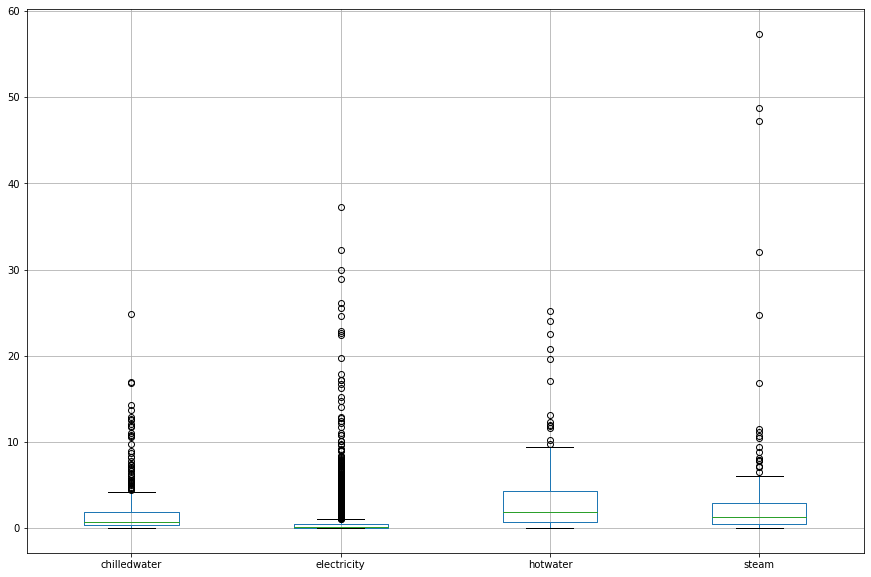

In [21]:
df_error_pivot = df_meter.merge(building_meta, on=['building_id', 'meter']).\
                 pivot_table(index='building_id',columns='meter',values='error_log_phase2',aggfunc='mean')
df_error_pivot.boxplot(figsize=(15,10))

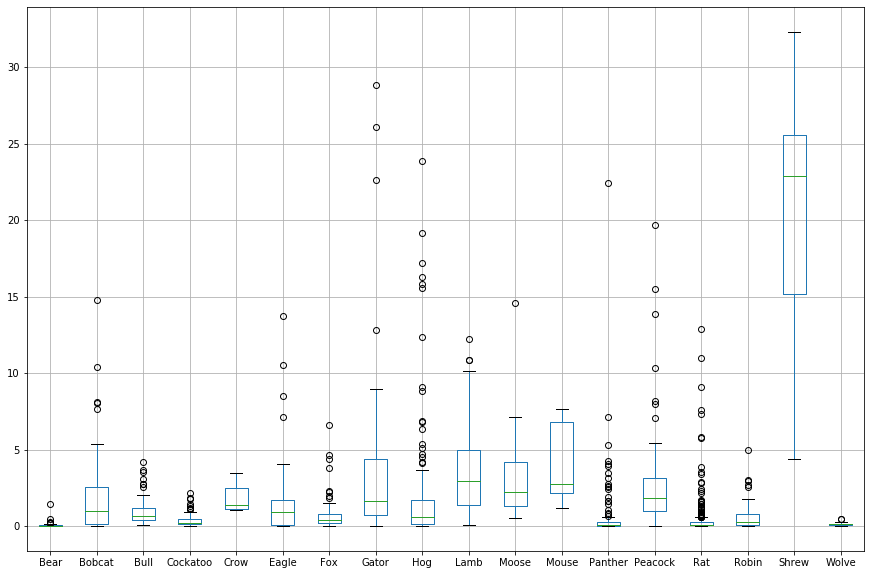

In [22]:
df_error_pivot = df_meter.merge(building_meta, on=['building_id', 'meter']).\
                 pivot_table(index='building_id',columns='site_id',values='error_log_phase2',aggfunc='mean')
df_error_pivot.boxplot(figsize=(15,10))

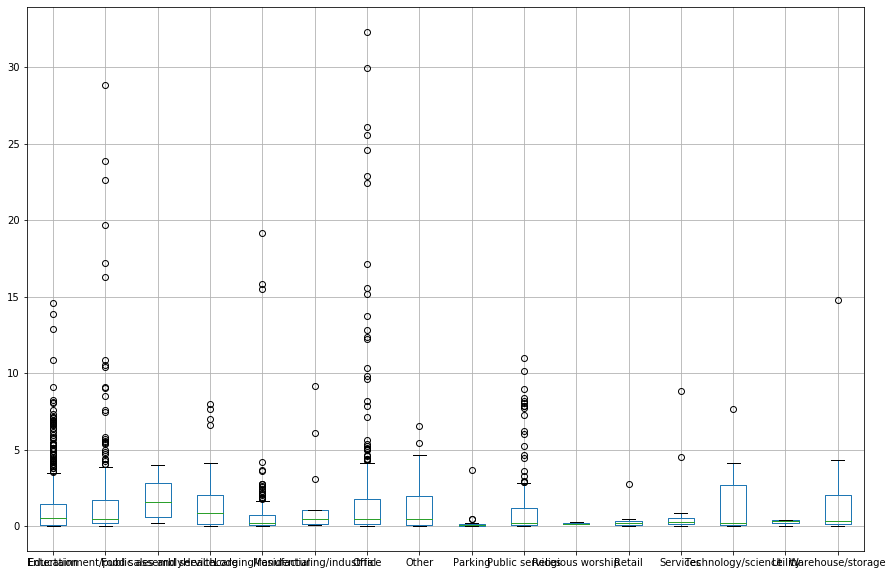

In [23]:
df_error_pivot = df_meter.merge(building_meta, on=['building_id', 'meter']).\
                 pivot_table(index='building_id',columns='primaryspaceusage',values='error_log_phase2',aggfunc='mean')
df_error_pivot.boxplot(figsize=(15,10))

In [49]:
df_error_pivot = df_meter.merge(building_meta, on=['building_id', 'meter']).\
                 pivot_table(index=['site_id','meter'],values=['error_log_phase1','error_log_phase2'],aggfunc='sum')
df_error_pivot['improvememt'] = df_error_pivot['error_log_phase2'] - df_error_pivot['error_log_phase1']

df_error_pivot.sort_values('improvememt')

,,error_log_phase1,error_log_phase2,improvememt
site_id,meter,,,
Gator,electricity,2.365568e+06,2.089631e+06,-275936.623415
Fox,hotwater,7.453499e+05,6.510777e+05,-94272.205109
Mouse,electricity,3.524673e+05,2.590254e+05,-93441.883695
Peacock,hotwater,2.811445e+06,2.724883e+06,-86562.012696
Hog,chilledwater,1.174050e+06,1.102518e+06,-71531.486828
Peacock,chilledwater,2.267562e+06,2.202168e+06,-65394.647687
Lamb,electricity,4.373056e+06,4.314368e+06,-58687.671089
Moose,chilledwater,5.631937e+05,5.134128e+05,-49780.844254
Eagle,steam,5.815282e+05,5.458052e+05,-35723.001492


In [60]:
df_error_pivot = df_meter.merge(building_meta, on=['building_id', 'meter']).\
                 pivot_table(index=['site_id','meter'],values=['error_log_phase1','error_log_phase2'],aggfunc='mean')
df_error_pivot['improvememt'] = df_error_pivot['error_log_phase2'] - df_error_pivot['error_log_phase1']

df_error_pivot.sort_values('improvememt')

,,error_log_phase1,error_log_phase2,improvememt
site_id,meter,,,
Mouse,electricity,5.759552,4.232649,-1.526903
Gator,electricity,4.064444,3.590339,-0.474106
Moose,chilledwater,4.306355,3.925715,-0.380640
Eagle,steam,3.085882,2.896317,-0.189564
Peacock,hotwater,5.355725,5.190827,-0.164898
Fox,hotwater,1.251545,1.093249,-0.158296
Hog,chilledwater,1.544138,1.450058,-0.094080
Peacock,steam,3.393494,3.304829,-0.088665
Bobcat,hotwater,7.483531,7.394896,-0.088634


building_id:  Eloisa_Crow_Education
meter:  chilledwater


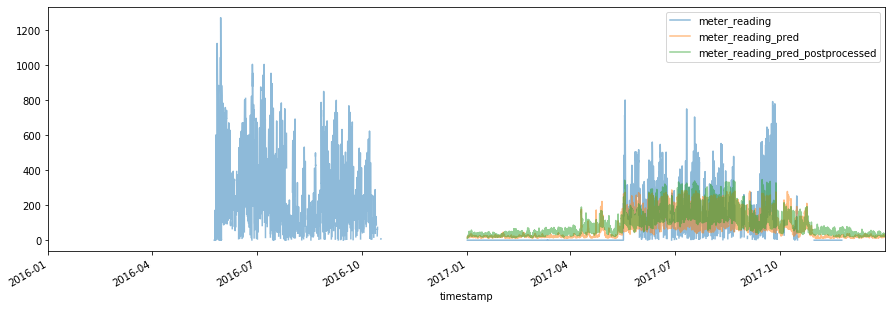

-----------------------------------------------------------------
building_id:  Beatrice_Crow_Education
meter:  chilledwater


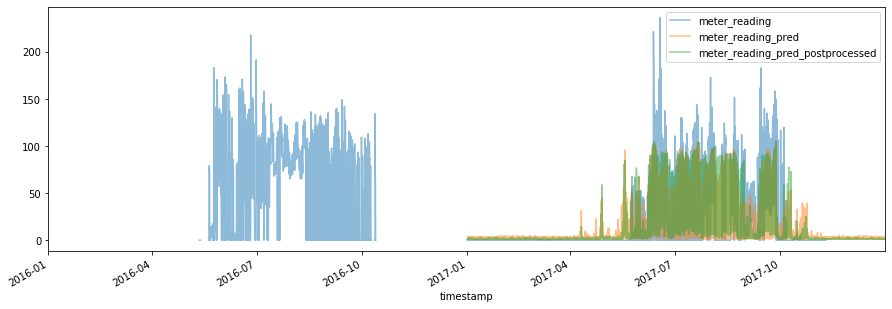

-----------------------------------------------------------------
building_id:  Leah_Crow_Education
meter:  chilledwater


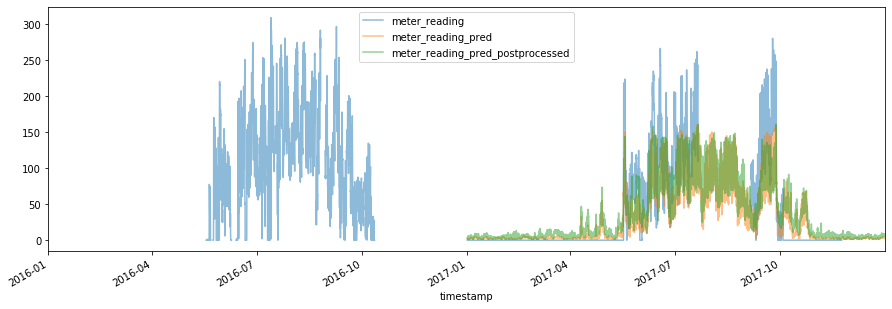

-----------------------------------------------------------------
building_id:  Hellen_Crow_Education
meter:  chilledwater


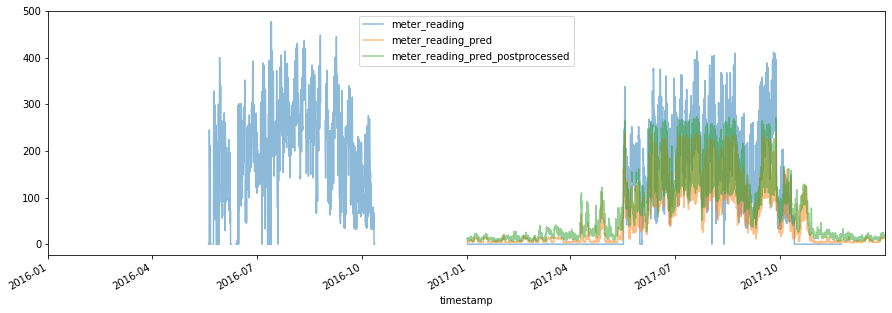

-----------------------------------------------------------------
building_id:  Sabrina_Crow_Education
meter:  chilledwater


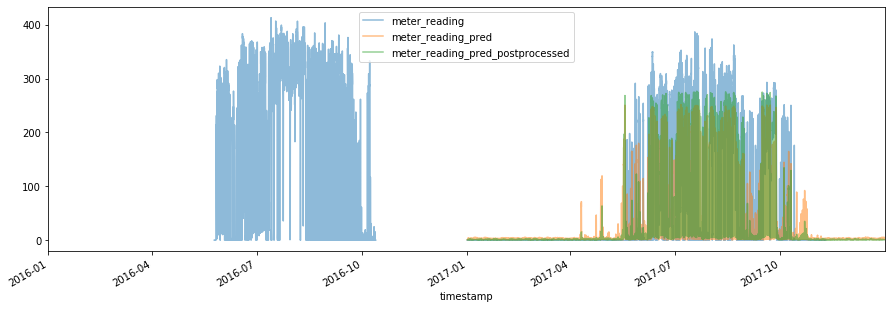

-----------------------------------------------------------------


In [62]:
site_id = 'Crow'
meter='chilledwater'
for building_id, meter in building_meta[(building_meta['site_id']==site_id)&(building_meta['meter']==meter)][['building_id','meter']].itertuples(index=False):
    print('building_id: ', building_id)
    print('meter: ', meter)    
    df_plot = df_meter[(df_meter['building_id']==building_id)&(df_meter['meter']==meter)][['timestamp','meter_reading','meter_reading_pred','meter_reading_pred_postprocessed']].set_index('timestamp')
    df_plot.plot(figsize=(15,5),alpha=0.5)
    plt.show()
    print('-----------------------------------------------------------------')    

In [26]:
building_meta['site_id'].value_counts()

Hog         336
Bull        308
Fox         302
Peacock     295
Rat         286
Cockatoo    253
Lamb        145
Panther     130
Bear         92
Eagle        81
Gator        74
Bobcat       66
Robin        64
Moose        42
Wolve        36
Crow         15
Shrew         9
Mouse         7
Name: site_id, dtype: int64

In [27]:
(df_meter['error_log_phase1'].mean())**0.5

1.2467774140096617

In [28]:
(df_meter['error_log_phase2'].mean())**0.5

1.2347277495072728

In [34]:
df_error_phase1 = df_meter.pivot_table(values='error_log_phase1',columns='meter',index='building_id',aggfunc='mean')**0.5
df_error_phase1

meter,chilledwater,electricity,hotwater,steam
building_id,,,,
Aaron_Panther_Education,2.048632,0.558216,NaN,NaN
Abbie_Hog_Education,NaN,2.697052,NaN,NaN
Abby_Bobcat_Education,2.485410,0.275507,2.705546,NaN
Ada_Lamb_Education,NaN,0.816161,NaN,NaN
Adam_Bull_Lodging/residential,0.527678,0.541515,NaN,0.807705
...,...,...,...,...
Zelma_Robin_Office,NaN,0.197856,NaN,NaN
Zenia_Robin_Lodging/residential,NaN,0.198816,NaN,NaN
Zina_Rat_Healthcare,NaN,0.256306,NaN,NaN


In [35]:
df_error_phase2 = df_meter.pivot_table(values='error_log_phase2',columns='meter',index='building_id',aggfunc='mean')**0.5
df_error_phase2

meter,chilledwater,electricity,hotwater,steam
building_id,,,,
Aaron_Panther_Education,2.044521,0.946613,NaN,NaN
Abbie_Hog_Education,NaN,2.625934,NaN,NaN
Abby_Bobcat_Education,2.513873,0.267871,2.566063,NaN
Ada_Lamb_Education,NaN,0.805902,NaN,NaN
Adam_Bull_Lodging/residential,0.527437,0.559120,NaN,0.716537
...,...,...,...,...
Zelma_Robin_Office,NaN,0.219337,NaN,NaN
Zenia_Robin_Lodging/residential,NaN,0.197148,NaN,NaN
Zina_Rat_Healthcare,NaN,0.228315,NaN,NaN


## Results

It is likely that a "Results" or "Results"-type section wold where much of the research analysis and reporting of results is likely to be found. This is likely to be a text that interpreses markup text, commented Python code, and generated outputs / visualization of code. When writing this section, authors should consider the following questions: can a reader understand how we are applying our methods? can a reader follow how the code has been written? can a reader replicate the results with the same data?

## Discussion

Last a "Discussion" and "Conclusions" section should discuss and summarize overall findings in the research work, as would be typically found in a research paper. These sections are not formally required, or should necessarily be titled as "Discussion", but the content of typical Discussion sections should be reflected in your Notebook

## References

A formatted referenece list is required at the end of each paper

Please upload your code and all supporting data files as a compressed .zip file to the eSim 2020 Conftool submission portal: https://www.conftool.com/esim2020
    

### Build Run-Time Environment
The following iPython Notebook was built and tested on the following run-time environment:

- Kaggle kernel notebooks